# Final Project Report

* Class: DS 5100
* Student Name: Sree Prabhav Bandakavi
* Student Net ID: kqy9hc
* This URL: https://github.com/SreeBand/DS5100_FinalProject/blob/main/Final_Project_SreePrabhavBandakavi.ipynb

# Instructions

Follow the instructions in the Final Project isntructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL: https://github.com/SreeBand/DS5100_FinalProject

Paste a copy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

```python
import numpy as np
import pandas as pd

class Die:
    """
    A Die has N sides, each with a unique symbol (numeric or string), and associated weights.
    The die can be rolled to randomly select a face based on these weights.

    By default, all weights are 1.0, representing a fair die.
    Weights can be modified after initialization.

    Attributes:
        __df (pd.DataFrame): Private dataframe storing faces and their weights.
    """

    def __init__(self, faces: np.ndarray):
        """
        Initializes a Die object with unique faces.

        Parameters:
            faces (np.ndarray): A NumPy array of unique face symbols (numeric or strings).

        Raises:
            TypeError: If faces is not a NumPy array.
            ValueError: If faces are not unique.
        """
        if not isinstance(faces, np.ndarray):
            raise TypeError("Faces must be provided as a NumPy array.")
        if len(faces) != len(set(faces)):
            raise ValueError("Faces must contain unique values.")
        
        self.__df = pd.DataFrame({
            'face': faces,
            'weight': np.ones(len(faces))
        }).set_index('face')

    def change_weight(self, face, new_weight):
        """
        Changes the weight of a specific face.

        Parameters:
            face: The face value whose weight is to be changed.
            new_weight: The new weight (float or int, must be non-negative).

        Raises:
            IndexError: If the face is not found.
            TypeError: If new_weight is not numeric or castable to float.
            ValueError: If new_weight is negative.

        State Changes:
            Updates the weight for the specified face.
        """
        if face not in self.__df.index:
            raise IndexError(f"Face '{face}' not found in die faces.")
        try:
            new_weight = float(new_weight)
        except ValueError:
            raise TypeError("New weight must be numeric or castable to float.")
        if new_weight < 0:
            raise ValueError("Weight must be non-negative.")
        
        self.__df.at[face, 'weight'] = new_weight

    def roll(self, num_rolls=1):
        """
        Rolls the die a specified number of times.

        Parameters:
            num_rolls (int): Number of times to roll the die (default is 1).

        Returns:
            list: A list of outcomes from the rolls.

        Raises:
            ValueError: If num_rolls is not a positive integer.

        Does not store results internally.
        """
        if not isinstance(num_rolls, int) or num_rolls <= 0:
            raise ValueError("Number of rolls must be a positive integer.")
        faces = self.__df.index.to_list()
        weights = self.__df['weight'].to_list()
        result = list(np.random.choice(faces, size=num_rolls, p=np.array(weights) / sum(weights)))
        return result

    def show(self):
        """
        Displays the current state of the die.

        Returns:
            pd.DataFrame: A copy of the dataframe showing faces and their weights.
        """
        return self.__df.copy()

class Game:
    """
    A Game consists of rolling one or more similar Die objects multiple times.
    It records the outcomes of the most recent play.

    Attributes:
        __dice (list): List of Die objects.
        __results (pd.DataFrame): Private dataframe storing latest play results.
    """

    def __init__(self, dice_list):
        """
        Initializes a Game with a list of Die objects.

        Parameters:
            dice_list (list): A list containing one or more Die objects.

        Raises:
            ValueError: If dice_list is empty or not a list.
        """
        if not isinstance(dice_list, list) or len(dice_list) == 0:
            raise ValueError("Must provide a non-empty list of dice.")
        self.__dice = dice_list
        self.__results = None

    def play(self, num_rolls):
        """
        Rolls all dice a specified number of times.

        Parameters:
            num_rolls (int): Number of times to roll the dice.

        Raises:
            ValueError: If num_rolls is not a positive integer.

        State Changes:
            Stores the results of the play in a private dataframe.
        """
        if not isinstance(num_rolls, int) or num_rolls <= 0:
            raise ValueError("Number of rolls must be a positive integer.")
        
        rolls = {}
        for i, die in enumerate(self.__dice):
            rolls[i] = die.roll(num_rolls)
        
        self.__results = pd.DataFrame(rolls)
        self.__results.index.name = "Roll Number"

    def show(self, form='wide'):
        """
        Displays the results of the most recent play.

        Parameters:
            form (str): 'wide' (default) or 'narrow' format.

        Returns:
            pd.DataFrame: Copy of the play results dataframe.

        Raises:
            ValueError: If no game has been played or invalid format is passed.
        """
        if self.__results is None:
            raise ValueError("No game has been played yet.")
        
        if form == 'wide':
            return self.__results.copy()
        elif form == 'narrow':
            narrow_df = self.__results.stack()
            narrow_df.index.set_names(['Roll Number', 'Die Number'], inplace=True)
            return narrow_df.to_frame('Outcome')
        else:
            raise ValueError("Invalid form. Use 'wide' or 'narrow'.")

class Analyzer:
    """
    Analyzer computes descriptive statistics from a single Game's results.

    Provides methods to compute jackpots, face counts, combinations, and permutations.
    """

    def __init__(self, game):
        """
        Initializes the Analyzer with a Game object.

        Parameters:
            game (Game): A Game object containing play results.

        Raises:
            ValueError: If input is not a Game object.
        """
        if not isinstance(game, Game):
            raise ValueError("Input must be a Game object.")
        self.game = game
        self.results = game.show('wide')

    def jackpot(self):
        """
        Computes the number of jackpots (all dice showing the same face in a roll).

        Returns:
            int: Number of jackpots found.
        """
        jackpots = self.results.apply(lambda row: len(set(row)) == 1, axis=1)
        return int(jackpots.sum())

    def face_counts_per_roll(self):
        """
        Counts occurrences of each face per roll.

        Returns:
            pd.DataFrame: DataFrame with roll numbers as index, face values as columns, and counts in cells.
        """
        counts_list = []
        unique_faces = pd.unique(self.results.values.ravel())
        for _, row in self.results.iterrows():
            counts = pd.Series(row).value_counts()
            counts = counts.reindex(unique_faces, fill_value=0)
            counts_list.append(counts)
        face_counts_df = pd.DataFrame(counts_list)
        face_counts_df.index = self.results.index
        face_counts_df.index.name = 'Roll Number'
        return face_counts_df

    def combo_count(self):
        """
        Computes distinct combinations (order-independent) of faces rolled and their counts.

        Returns:
            pd.DataFrame: DataFrame with MultiIndex of combinations and a count column.
        """
        combos = self.results.apply(lambda row: tuple(sorted(row)), axis=1)
        combo_counts = combos.value_counts().to_frame('Count')
        combo_counts.index.name = 'Combination'
        return combo_counts

    def permutation_count(self):
        """
        Computes distinct permutations (order-dependent) of faces rolled and their counts.

        Returns:
            pd.DataFrame: DataFrame with MultiIndex of permutations and a count column.
        """
        perms = self.results.apply(lambda row: tuple(row), axis=1)
        perm_counts = perms.value_counts().to_frame('Count')
        perm_counts.index.name = 'Permutation'
        return perm_counts
```

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

```python
import unittest
import numpy as np
import pandas as pd
from die_game_analyzer import Die, Game, Analyzer

class TestDieGameAnalyzer(unittest.TestCase):

    def setUp(self):
        """Set up common test objects for Die, Game, and Analyzer."""
        self.faces = np.array([1, 2, 3, 4, 5, 6])
        self.die = Die(self.faces)
        self.dice_list = [self.die, Die(self.faces)]
        self.game = Game(self.dice_list)
        self.game.play(5)
        self.analyzer = Analyzer(self.game)

    # --- Tests for Die Class (4 methods) ---

    def test_die_init_creates_dataframe(self):
        """Test Die initialization creates correct DataFrame structure."""
        df = self.die.show()
        self.assertIsInstance(df, pd.DataFrame)
        self.assertTrue((df['weight'] == 1.0).all())

    def test_die_change_weight_updates_weight(self):
        """Test that changing a weight updates the DataFrame correctly."""
        self.die.change_weight(6, 3.5)
        df = self.die.show()
        self.assertEqual(df.loc[6, 'weight'], 3.5)

    def test_die_roll_returns_correct_length_list(self):
        """Test that Die.roll() returns a list of correct length."""
        outcomes = self.die.roll(4)
        self.assertIsInstance(outcomes, list)
        self.assertEqual(len(outcomes), 4)

    def test_die_show_returns_dataframe(self):
        """Test that Die.show() returns a DataFrame."""
        result = self.die.show()
        self.assertIsInstance(result, pd.DataFrame)

    # --- Tests for Game Class (3 methods) ---

    def test_game_init_accepts_dice_list(self):
        """Test Game initialization with dice list."""
        game = Game(self.dice_list)
        self.assertIsInstance(game, Game)

    def test_game_play_creates_results_dataframe(self):
        """Test Game.play() stores a DataFrame of correct shape."""
        df = self.game.show('wide')
        self.assertIsInstance(df, pd.DataFrame)
        self.assertEqual(df.shape, (5, len(self.dice_list)))

    def test_game_show_formats(self):
        """Test Game.show() returns correct formats."""
        wide_df = self.game.show('wide')
        narrow_df = self.game.show('narrow')
        self.assertIsInstance(wide_df, pd.DataFrame)
        self.assertIsInstance(narrow_df, pd.DataFrame)
        self.assertIsInstance(narrow_df.index, pd.MultiIndex)

    # --- Tests for Analyzer Class (5 methods) ---

    def test_analyzer_init_stores_results(self):
        """Test Analyzer initialization stores game results."""
        self.assertIsInstance(self.analyzer.results, pd.DataFrame)

    def test_analyzer_jackpot_returns_integer(self):
        """Test that Analyzer.jackpot() returns an integer."""
        jackpots = self.analyzer.jackpot()
        self.assertIsInstance(jackpots, int)

    def test_analyzer_face_counts_per_roll_structure(self):
        """Test that face_counts_per_roll returns a DataFrame."""
        counts_df = self.analyzer.face_counts_per_roll()
        self.assertIsInstance(counts_df, pd.DataFrame)
        self.assertEqual(counts_df.shape[0], self.game.show().shape[0])

    def test_analyzer_combo_count_returns_dataframe(self):
        """Test combo_count returns a DataFrame with MultiIndex."""
        combo_df = self.analyzer.combo_count()
        self.assertIsInstance(combo_df, pd.DataFrame)
        self.assertTrue(isinstance(combo_df.index, pd.Index) or isinstance(combo_df.index, pd.MultiIndex))

    def test_analyzer_permutation_count_returns_dataframe(self):
        """Test permutation_count returns a DataFrame with MultiIndex."""
        perm_df = self.analyzer.permutation_count()
        self.assertIsInstance(perm_df, pd.DataFrame)
        self.assertTrue(isinstance(perm_df.index, pd.Index) or isinstance(perm_df.index, pd.MultiIndex))


if __name__ == '__main__':
    unittest.main()
```

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [5]:
from monte_carlo_simulator.die_game_analyzer import Die, Game, Analyzer

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [9]:
import monte_carlo_simulator.die_game_analyzer
help(monte_carlo_simulator.die_game_analyzer)

Help on module monte_carlo_simulator.die_game_analyzer in monte_carlo_simulator:

NAME
    monte_carlo_simulator.die_game_analyzer

CLASSES
    builtins.object
        Analyzer
        Die
        Game
    
    class Analyzer(builtins.object)
     |  Analyzer(game)
     |  
     |  Analyzer computes descriptive statistics from a single Game's results.
     |  
     |  Provides methods to compute jackpots, face counts, combinations, and permutations.
     |  
     |  Methods defined here:
     |  
     |  __init__(self, game)
     |      Initializes the Analyzer with a Game object.
     |      
     |      Parameters:
     |          game (Game): A Game object containing play results.
     |      
     |      Raises:
     |          ValueError: If input is not a Game object.
     |  
     |  combo_count(self)
     |      Computes distinct combinations (order-independent) of faces rolled and their counts.
     |      
     |      Returns:
     |          pd.DataFrame: DataFrame with Mult

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL: https://github.com/SreeBand/DS5100_FinalProject/blob/main/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [54]:
import numpy as np
import pandas as pd
from monte_carlo_simulator.die_game_analyzer import Die

faces = np.array(['H', 'T'])
fair_coin = Die(faces)

unfair_coin = Die(faces)
unfair_coin.change_weight('H', 5)

print("Fair Coin State:")
print(fair_coin.show())

print("\nUnfair Coin State:")
print(unfair_coin.show())

Fair Coin State:
      weight
face        
H        1.0
T        1.0

Unfair Coin State:
      weight
face        
H        5.0
T        1.0


Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [55]:
import numpy as np
from monte_carlo_simulator.die_game_analyzer import Die, Game

faces = np.array(['H', 'T'])
fair_coin1 = Die(faces)
fair_coin2 = Die(faces)

game = Game([fair_coin1, fair_coin2])

game.play(1000)

print(game.show('wide'))
total_counts = game.show('wide').apply(pd.Series.value_counts).sum(axis=1)
print(f"T: {total_counts.get('T', 0)}  H: {total_counts.get('H', 0)}")


             0  1
Roll Number      
0            H  H
1            H  T
2            T  H
3            T  T
4            H  T
...         .. ..
995          T  T
996          T  T
997          H  T
998          T  H
999          H  T

[1000 rows x 2 columns]
T: 1024  H: 976


Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [56]:
game2 = Game([unfair_coin, unfair_coin, fair_coin1])
game2.play(1000)

print(game2.show('wide'))

total_counts2 = game2.show('wide').apply(pd.Series.value_counts).sum(axis=1)
print(f"T: {total_counts2.get('T', 0)}  H: {total_counts2.get('H', 0)}")


             0  1  2
Roll Number         
0            H  H  T
1            T  H  H
2            H  H  T
3            H  H  H
4            T  H  T
...         .. .. ..
995          H  H  H
996          T  H  T
997          H  H  H
998          H  H  H
999          H  H  T

[1000 rows x 3 columns]
T: 854  H: 2146


Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [57]:
from monte_carlo_simulator.die_game_analyzer import Analyzer

analyzer1 = Analyzer(game)
jackpots1 = analyzer1.jackpot()
print(f"Game 1 (2 Fair Coins) - Number of Jackpots: {jackpots1}")

analyzer2 = Analyzer(game2)
jackpots2 = analyzer2.jackpot()
print(f"Game 2 (2 Unfair + 1 Fair Coin) - Number of Jackpots: {jackpots2}")


Game 1 (2 Fair Coins) - Number of Jackpots: 494
Game 2 (2 Unfair + 1 Fair Coin) - Number of Jackpots: 330


Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [58]:
total_rolls_game1 = game.show('wide').shape[0]
total_rolls_game2 = game2.show('wide').shape[0]

relative_freq1 = jackpots1 / total_rolls_game1
relative_freq2 = jackpots2 / total_rolls_game2

print(f"Game 1 (2 Fair Coins) - Relative Jackpot Frequency: {relative_freq1:.4f}")
print(f"Game 2 (2 Unfair + 1 Fair Coin) - Relative Jackpot Frequency: {relative_freq2:.4f}")


Game 1 (2 Fair Coins) - Relative Jackpot Frequency: 0.4940
Game 2 (2 Unfair + 1 Fair Coin) - Relative Jackpot Frequency: 0.3300


Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

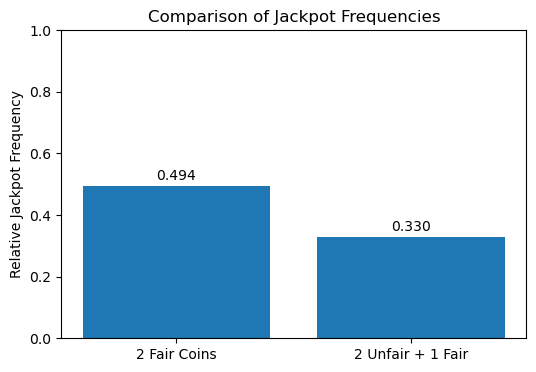

In [59]:
import matplotlib.pyplot as plt

games = ['2 Fair Coins', '2 Unfair + 1 Fair']
relative_frequencies = [relative_freq1, relative_freq2]

plt.figure(figsize=(6, 4))
plt.bar(games, relative_frequencies)
plt.ylim(0, 1)
plt.ylabel('Relative Jackpot Frequency')
plt.title('Comparison of Jackpot Frequencies')

for i, freq in enumerate(relative_frequencies):
    plt.text(i, freq + 0.02, f"{freq:.3f}", ha='center')

plt.show()


## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [7]:
import numpy as np
from monte_carlo_simulator.die_game_analyzer import Die

faces = np.array([1, 2, 3, 4, 5, 6])

die1 = Die(faces)
die2 = Die(faces)
die3 = Die(faces)

print(die1.show(), die2.show(), die3.show())

      weight
face        
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0       weight
face        
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0       weight
face        
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0


Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [8]:
die1.change_weight(6, 5)

print(die1.show())

      weight
face        
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        5.0


Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [9]:
die2.change_weight(1, 5)

print(die2.show())

      weight
face        
1        5.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0


Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [10]:
import numpy as np
from monte_carlo_simulator.die_game_analyzer import Die, Game

faces = np.array([1, 2, 3, 4, 5, 6])
fair_dice = [Die(faces) for _ in range(5)]

game = Game(fair_dice)

game.play(10000)

print(game.show('wide'))

             0  1  2  3  4
Roll Number               
0            1  4  3  2  3
1            1  1  4  6  2
2            6  3  5  6  6
3            3  6  4  1  3
4            6  5  6  6  1
...         .. .. .. .. ..
9995         6  3  4  6  2
9996         1  6  3  4  2
9997         4  5  4  1  3
9998         6  3  5  6  4
9999         2  6  5  4  3

[10000 rows x 5 columns]


Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [15]:
fair_dice = [Die(faces) for _ in range(3)]

game2 = Game([die1, die2] + fair_dice)
game2.play(10000)

print(game2.show('wide'))

             0  1  2  3  4
Roll Number               
0            6  4  6  1  5
1            4  1  5  6  2
2            6  3  4  2  2
3            6  5  5  2  5
4            3  2  3  6  4
...         .. .. .. .. ..
9995         6  6  1  4  3
9996         4  2  3  2  5
9997         3  1  2  6  2
9998         6  1  6  4  3
9999         6  4  4  5  1

[10000 rows x 5 columns]


Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

5 Fair Dice - Jackpots: 6, Relative Frequency: 0.0006
2 Unfair + 3 Fair Dice - Jackpots: 6, Relative Frequency: 0.0006


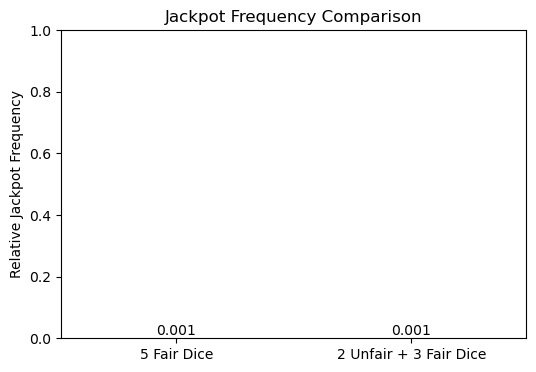

In [16]:
from monte_carlo_simulator.die_game_analyzer import Analyzer
import matplotlib.pyplot as plt

analyzer_fair = Analyzer(game)
analyzer_mixed = Analyzer(game2)

jackpots_fair = analyzer_fair.jackpot()
jackpots_mixed = analyzer_mixed.jackpot()

total_rolls = 10000
rel_freq_fair = jackpots_fair / total_rolls
rel_freq_mixed = jackpots_mixed / total_rolls

print(f"5 Fair Dice - Jackpots: {jackpots_fair}, Relative Frequency: {rel_freq_fair:.4f}")
print(f"2 Unfair + 3 Fair Dice - Jackpots: {jackpots_mixed}, Relative Frequency: {rel_freq_mixed:.4f}")

games = ['5 Fair Dice', '2 Unfair + 3 Fair Dice']
frequencies = [rel_freq_fair, rel_freq_mixed]

plt.figure(figsize=(6, 4))
plt.bar(games, frequencies)
plt.ylim(0, 1)
plt.ylabel('Relative Jackpot Frequency')
plt.title('Jackpot Frequency Comparison')

for i, freq in enumerate(frequencies):
    plt.text(i, freq + 0.01, f"{freq:.3f}", ha='center')

plt.show()


## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [17]:
import numpy as np
import pandas as pd
from monte_carlo_simulator.die_game_analyzer import Die

letter_freq = pd.read_csv('english_letters.txt', sep=' ', header=None, names=['Letter', 'Frequency'])

faces = letter_freq['Letter'].values
weights = letter_freq['Frequency'].values

letter_die = Die(faces)

for letter, weight in zip(faces, weights):
    letter_die.change_weight(letter, weight)
print(letter_die.show())

           weight
face             
E     529117365.0
T     390965105.0
A     374061888.0
O     326627740.0
I     320410057.0
N     313720540.0
S     294300210.0
R     277000841.0
H     216768975.0
L     183996130.0
D     169330528.0
C     138416451.0
U     117295780.0
M     110504544.0
F      95422055.0
G      91258980.0
P      90376747.0
W      79843664.0
Y      75294515.0
B      70195826.0
V      46337161.0
K      35373464.0
J       9613410.0
X       8369915.0
Z       4975847.0
Q       4550166.0


Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [18]:
from monte_carlo_simulator.die_game_analyzer import Game

letter_dice = [letter_die] * 4
letter_game = Game(letter_dice)

letter_game.play(1000)

print(letter_game.show('wide'))

             0  1  2  3
Roll Number            
0            O  T  L  F
1            R  O  S  N
2            T  S  R  C
3            I  T  L  R
4            P  T  A  D
...         .. .. .. ..
995          E  M  A  R
996          I  L  E  I
997          D  E  M  R
998          D  T  N  D
999          E  S  H  T

[1000 rows x 4 columns]


Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [20]:
letter_analyzer = Analyzer(letter_game)
permutations_df = letter_analyzer.permutation_count()

permutations_df = permutations_df.reset_index()
permutations_df['Word'] = permutations_df['Permutation'].apply(lambda x: ''.join(x))

with open('scrabble_words.txt', 'r') as f:
    scrabble_words = set(word.strip().upper() for word in f if len(word.strip()) == 4)

valid_words_df = permutations_df[permutations_df['Word'].isin(scrabble_words)]

num_valid_words = valid_words_df['Count'].sum()

print(f"Number of valid English words found: {num_valid_words}")
print("\nValid words and their counts:")
print(valid_words_df[['Word', 'Count']])

Number of valid English words found: 50

Valid words and their counts:
     Word  Count
12   FINE      1
24   EROS      1
31   OPAL      1
59   ERNS      1
81   NODE      1
105  NAPA      1
129  OMER      1
164  STOT      1
174  BURA      1
189  ECUS      1
199  BEET      1
201  SNEE      1
202  MENO      1
214  AMIA      1
247  OILS      1
257  ETEN      1
267  CORF      1
282  DENE      1
295  EONS      1
296  SLEE      1
303  SESE      1
311  WASE      1
323  SNAR      1
348  SEEL      1
355  HUTS      1
407  MOTH      1
473  ATES      1
485  TASE      1
500  STEM      1
530  ENES      1
549  GOLE      1
550  WAID      1
578  CILL      1
630  ANIL      1
649  EAST      1
669  ICER      1
671  PACA      1
705  NOOP      1
744  GEAT      1
746  SHAD      1
762  TORO      1
765  CRED      1
813  ROHE      1
818  EDDO      1
832  TATH      1
882  NEAR      1
893  HAEN      1
924  SOUL      1
936  MEMS      1
943  TWIN      1


Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [22]:
letter_dice_5 = [letter_die] * 5

letter_game_5 = Game(letter_dice_5)
letter_game_5.play(1000)

print(letter_game_5.show('wide'))

             0  1  2  3  4
Roll Number               
0            E  A  A  F  R
1            I  E  F  E  F
2            L  P  N  A  A
3            S  U  E  T  T
4            F  A  T  Y  A
...         .. .. .. .. ..
995          A  F  T  N  I
996          U  E  R  R  L
997          S  S  A  T  C
998          I  O  T  S  J
999          R  O  O  O  E

[1000 rows x 5 columns]


In [24]:
analyzer_5 = Analyzer(letter_game_5)
permutations_5_df = analyzer_5.permutation_count()

permutations_5_df = permutations_5_df.reset_index()
permutations_5_df['Word'] = permutations_5_df['Permutation'].apply(lambda x: ''.join(x))

with open('scrabble_words.txt', 'r') as f:
    scrabble_words_5 = set(word.strip().upper() for word in f if len(word.strip()) == 5)

valid_words_5_df = permutations_5_df[permutations_5_df['Word'].isin(scrabble_words_5)]

num_valid_words_5 = valid_words_5_df['Count'].sum()

print(f"Number of valid English words (5 dice): {num_valid_words_5}")
print(valid_words_5_df[['Word', 'Count']])

Number of valid English words (5 dice): 11
      Word  Count
33   HOWRE      1
195  CLEAT      1
222  TITLE      1
358  TWAYS      1
455  ETENS      1
526  THROB      1
783  STATE      1
798  TRIER      1
824  AMEND      1
836  STARR      1
895  STENT      1


Number of valid English words found: 50  
Number of valid English words (5 dice): 11  

There are **more 4 letter words** compared to the 5 letter words. This is due to the increased complexity that comes with adding more letters. Also due to the weighted nature of the dice shorter words are more likely to appear.  